# 관련 패키지들을 import 합니다.

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 데이터셋을 로드합니다.

In [2]:
df = pd.read_csv('./tsp_dataset/climate_preprocessed.csv', encoding='utf-8')

In [3]:
df.pop('Unnamed: 0')
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
0,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503,-0.866025,-5.000000e-01,0.003598,0.999994
1,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645,-0.965926,-2.588190e-01,0.004315,0.999991
2,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,-1.000000,7.867334e-13,0.005032,0.999987
3,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090,-0.965926,2.588190e-01,0.005749,0.999983
4,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843,-0.866025,5.000000e-01,0.006465,0.999979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70086,1002.18,-0.98,272.01,-5.36,72.00,5.69,4.09,1.59,2.54,4.08,1280.70,-0.855154,-0.160038,-1.336792,-0.250174,0.461749,-8.870108e-01,0.000449,1.000000
70087,1001.40,-1.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,-0.716196,-0.726267,-1.348134,-1.367090,0.216440,-9.762960e-01,0.001166,0.999999
70088,1001.19,-2.75,270.32,-6.90,72.90,4.99,3.64,1.35,2.26,3.63,1288.02,-0.661501,0.257908,-1.453438,0.566672,-0.043619,-9.990482e-01,0.001883,0.999998
70089,1000.65,-2.89,270.22,-7.15,72.30,4.93,3.57,1.37,2.22,3.57,1288.03,-0.280621,-0.209169,-0.545207,-0.406385,-0.300706,-9.537170e-01,0.002600,0.999997


# Data split

데이터 분할
훈련, 검증 및 테스트 세트에 (70%, 20%, 10%) 분할을 사용합니다. 분할하기 전에 데이터가 임의로 셔플되지 않습니다. 이것은 두 가지 이유 때문입니다.

데이터를 연속된 샘플의 창으로 자르는 것이 여전히 가능합니다.
모델을 훈련한 후 수집된 데이터를 바탕으로 평가하므로 검증/테스트 결과가 보다 현실적입니다.

In [4]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]


train_date_time = date_time[0:int(n*0.7)]
val_date_time = date_time[int(n*0.7):int(n*0.9)]
test_date_time = date_time[int(n*0.9):]

num_features = df.shape[1]

In [5]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [6]:
T_std = train_std['T (degC)']
T_mean = train_mean['T (degC)']

p_std = train_std['p (mbar)']
p_mean = train_mean['p (mbar)']

In [7]:
train_df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
0,0.945308,-1.982473,-2.041888,-1.918973,1.117102,-1.302851,-1.477323,-0.790424,-1.480036,-1.482697,2.218524,0.193409,0.221161,0.111140,0.217928,-1.224805,-0.707149,-0.070413,1.427922
1,0.959770,-2.078372,-2.138166,-2.060964,1.044617,-1.330143,-1.534354,-0.786272,-1.536190,-1.539035,2.325708,0.172987,0.222101,0.109458,0.227798,-1.366078,-0.366056,-0.069389,1.427918
2,0.986284,-2.070284,-2.132435,-2.045187,1.062738,-1.328843,-1.527225,-0.788348,-1.528703,-1.531992,2.323998,0.207983,0.276266,0.111218,0.324078,-1.414264,-0.000018,-0.068366,1.427913
3,1.004362,-2.098014,-2.161090,-2.096820,1.008375,-1.336641,-1.546235,-0.782121,-1.547420,-1.553119,2.358913,0.270343,0.195267,0.246907,0.145176,-1.366078,0.366020,-0.067343,1.427908
4,1.061006,-2.165028,-2.232152,-2.187178,0.984214,-1.353535,-1.579503,-0.782121,-1.581113,-1.585982,2.446320,0.112264,0.350818,0.048640,0.402053,-1.224805,0.707113,-0.066320,1.427901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49058,0.169167,0.904892,0.886564,1.571997,0.947972,0.776492,1.984916,-0.493604,1.979016,1.977352,-0.882480,-0.166720,-1.508412,-0.155728,-1.363530,-0.061811,-1.412933,-0.847503,-1.159944
49059,0.266787,0.879473,0.853325,1.405624,0.621793,0.742703,1.680752,-0.283962,1.672043,1.672192,-0.822662,-0.824901,-0.641039,-0.704391,-0.475387,-0.425366,-1.348823,-0.848364,-1.159398
49060,0.217374,0.740824,0.719224,1.425703,1.086900,0.559461,1.716396,-0.605690,1.709479,1.707403,-0.716211,-0.030746,0.645277,0.013960,0.600050,-0.759942,-1.192794,-0.849224,-1.158853
49061,0.213759,0.710783,0.689423,1.412795,1.147303,0.521772,1.692633,-0.645127,1.687018,1.683929,-0.689842,0.014300,-0.102616,-0.095117,-0.198426,-1.042738,-0.955479,-0.850083,-1.158306


In [8]:
val_df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
49063,0.213759,0.618351,0.597730,1.321003,1.207707,0.407409,1.535799,-0.688716,1.526045,1.526654,-0.601703,0.072253,-0.639008,0.089478,-0.535618,-1.380743,-0.306120,-0.851802,-1.157212
49064,0.241478,0.545560,0.523229,1.260764,1.286231,0.321636,1.433619,-0.738532,1.424968,1.423369,-0.526259,0.071987,-0.233849,0.079109,-0.188724,-1.412918,0.061671,-0.852660,-1.156664
49065,0.258351,0.510898,0.487698,1.249290,1.370796,0.282648,1.414609,-0.784197,1.406250,1.404590,-0.490612,-0.459268,0.629912,-0.526513,0.659056,-1.348813,0.425258,-0.853518,-1.156115
49066,0.277634,0.487789,0.463629,1.227776,1.388917,0.256656,1.378964,-0.794575,1.368815,1.367032,-0.463755,-0.086355,-0.297434,-0.068182,-0.229261,-1.192798,0.759864,-0.854376,-1.155565
49067,0.294506,0.502810,0.476236,1.255027,1.413079,0.273551,1.424114,-0.807029,1.413738,1.413979,-0.474987,-0.421783,0.109299,-0.413007,0.139150,-0.955504,1.042685,-0.855233,-1.155015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63076,1.447871,-0.708058,-0.814346,-0.543525,0.585551,-0.751825,-0.683646,-0.603614,-0.701375,-0.701017,1.032666,1.972660,1.474668,1.879942,1.333168,1.414010,-0.000018,1.257836,0.524029
63077,1.447871,-0.713835,-0.821223,-0.496195,0.730519,-0.755724,-0.645625,-0.643052,-0.667683,-0.665806,1.037061,1.683218,1.168334,1.824204,1.199236,1.365825,-0.366056,1.258200,0.523088
63078,1.476795,-0.787781,-0.895723,-0.513406,0.929851,-0.798610,-0.659883,-0.699095,-0.678914,-0.679891,1.116167,1.865699,2.069800,1.642021,1.702072,1.224552,-0.707149,1.258565,0.522146
63079,1.503309,-0.765828,-0.875092,-0.489023,0.917770,-0.785615,-0.640873,-0.694943,-0.660196,-0.661111,1.100053,1.818145,1.318900,1.568811,1.089944,0.999819,-1.000052,1.258928,0.521205


# Data batch를 정의합니다. 

`idx_start` ~ `idx_end` 의 데이터로 CNN 입출력을 구성합니다.

In [9]:
def make_batch_from_df(df, idx_start, idx_end, sequence_length):

    sl = sequence_length    

    print("idx _start : {} . idx_end : {}".format(idx_start, idx_end))    
    print("Sequence Length : {}".format(sl))

    train_range = range(idx_start, idx_end + 1 -sl + 1)
    train_Y_range =  range(idx_start + sl -1, idx_end + 1)

    print("train_range: {}".format(train_range))    
    print("train_Y_range: {}".format(train_Y_range))        
    
    rows, cols = df.shape

    Y_df = pd.DataFrame(data=df,  columns=['p (mbar)', 'T (degC)'])
    U_df = pd.DataFrame(data=df,  columns=[k for k in df.keys() if not k.startswith('T') and k != 'p (mbar)'])
   
    train_U_df = pd.DataFrame(data=U_df, index=range(idx_start, idx_end + 1))
    # train_U_df = train_U_df.clip(-3, 3) / 3     ## CLIP and NORMALIZE
    
    
    train_Y_df = pd.DataFrame(data=Y_df, index=train_Y_range)
    
    
    train_u = []
    train_x = []    
    label_y = []

    for i in train_range:
        train_seq = U_df[i:i+sl].to_numpy()
        train_u.append(train_seq)

    for i in train_range:
        train_seq = Y_df[i:i+sl - 1].to_numpy()
        train_x.append(train_seq)
        
    for i in train_Y_range:
        train_label = Y_df[i : i + 1].to_numpy()
        label_y.append(train_label)        

    tensor_u, tensor_x, tensor_y = torch.Tensor(train_u), torch.Tensor(train_x) , torch.Tensor(label_y)
    print("U input : {}".format(tensor_u.shape))    
    print("X input : {}".format(tensor_x.shape))        
    print("Y input : {}".format(tensor_y.shape))        
        
    return tensor_u, tensor_x, tensor_y, train_Y_df, train_U_df

# Set train / validation set

In [10]:
idx_start = 0
idx_end = 24*365

# idx_val_end = 60000

sequence_length = 5

print("=== TRAIN ====")
tensor_u, tensor_x, tensor_y, train_Y_df, train_U_df = make_batch_from_df(train_df, idx_start, idx_end, sequence_length)


# print("=== TEST ====")
# val_tensor_u, val_tensor_x, val_tensor_y, val_Y_df, val_U_df  = make_batch_from_df(df, idx_end - sequence_length, idx_val_end, sequence_length)

=== TRAIN ====
idx _start : 0 . idx_end : 8760
Sequence Length : 5
train_range: range(0, 8757)
train_Y_range: range(4, 8761)
U input : torch.Size([8757, 5, 15])
X input : torch.Size([8757, 4, 2])
Y input : torch.Size([8757, 1, 2])


/tmp/ipykernel_31243/294341225.py:42: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272107467/work/torch/csrc/utils/tensor_new.cpp:201.)
  tensor_u, tensor_x, tensor_y = torch.Tensor(train_u), torch.Tensor(train_x) , torch.Tensor(label_y)


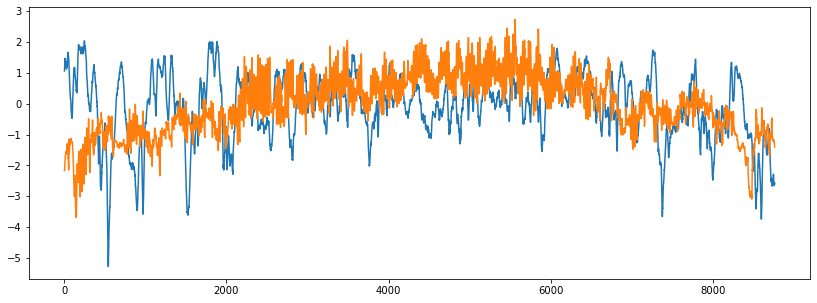

In [11]:
fig = plt.figure(figsize=(14,5))
plt.plot(train_Y_df)

In [12]:
train_date_time[:idx_end+1]

0      2009-01-01 01:00:00
1      2009-01-01 02:00:00
2      2009-01-01 03:00:00
3      2009-01-01 04:00:00
4      2009-01-01 05:00:00
               ...        
8756   2009-12-31 21:20:00
8757   2009-12-31 22:20:00
8758   2009-12-31 23:20:00
8759   2010-01-01 00:20:00
8760   2010-01-01 01:20:00
Name: Date Time, Length: 8761, dtype: datetime64[ns]

# CNN model

- `sequence_length` : Batch data 때 정의하며 tuning 필요. 이 값에 따라 CNN 모델의 time_conv 의 filter dimension 조절 필요.
- `input_size` 는 U에 의해, `output_size`는 Y에 의해 불변. 모델 정의에 필요함.
- 그외 `num_layers`, MLP의 차원 및 layer 개수

In [13]:
class CNN(nn.Module):
    
    def __init__(self, input_size, sequence_length, output_size=1):
        super().__init__()

        self.time_conv = nn.Sequential(      
                    nn.Conv1d(input_size, input_size, 3),     
                    nn.Tanh(),            
                    nn.Conv1d(input_size, input_size, 3),                    
                    nn.Tanh(),
        )
        
        self.x_conv = nn.Sequential(      
                    nn.Conv1d(sequence_length - 1, sequence_length - 1, 2),     
                    nn.Tanh(),            
        )        
        
        self.linear = nn.Sequential(
            # X input length : sequence_length -1
            nn.Linear(input_size + sequence_length - 1, 50),  
            nn.ReLU(),            
            nn.Linear(50, 30),
            nn.ReLU(),            
            nn.Linear(30, 10),
            nn.ReLU(),            
            nn.Linear(10,output_size)
        )
        
    def forward(self, u, x):
        b, ll, tt = u.shape
        u = u.reshape(b, tt, ll)
        output  = self.time_conv(u)
        
        x  = self.x_conv(x)        
        
        ## Concatenate X input to U
        output = torch.cat([output, x], axis=1)
        
        return self.linear(output[..., 0])        

In [14]:
input_size = tensor_u.shape[2]
batch_size = tensor_u.shape[0]
output_size = tensor_y.shape[2]

torch.manual_seed(0)
model = CNN(input_size, sequence_length, output_size)
model

CNN(
  (time_conv): Sequential(
    (0): Conv1d(15, 15, kernel_size=(3,), stride=(1,))
    (1): Tanh()
    (2): Conv1d(15, 15, kernel_size=(3,), stride=(1,))
    (3): Tanh()
  )
  (x_conv): Sequential(
    (0): Conv1d(4, 4, kernel_size=(2,), stride=(1,))
    (1): Tanh()
  )
  (linear): Sequential(
    (0): Linear(in_features=19, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=2, bias=True)
  )
)

# Train loop

In [15]:
lr = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
epochs = 300

for i in range(epochs):
    model.train()
    
    output = model(tensor_u, tensor_x)
    
    # flatten output_size into (n, 1) to calculate loss
    loss = criterion(output.view(-1,1), tensor_y.view(-1,1))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i%25 == 0:
        print('Epoch {}, Loss {:.5f}'.format(i, loss.item()))

Epoch 0, Loss 1.08441
Epoch 25, Loss 0.97540
Epoch 50, Loss 0.63290
Epoch 75, Loss 0.26771
Epoch 100, Loss 0.10500
Epoch 125, Loss 0.04602
Epoch 150, Loss 0.02694
Epoch 175, Loss 0.01752
Epoch 200, Loss 0.01203
Epoch 225, Loss 0.00872
Epoch 250, Loss 0.00664
Epoch 275, Loss 0.00525


# Validation

In [16]:
val_df = val_df.reset_index()
val_df.pop('index')

0        49063
1        49064
2        49065
3        49066
4        49067
         ...  
14013    63076
14014    63077
14015    63078
14016    63079
14017    63080
Name: index, Length: 14018, dtype: int64

In [17]:
val_idx_start = 24 * 7
val_idx_end =  24 * 7 * 2

sequence_length = 5


val_tensor_u, val_tensor_x, val_tensor_y, val_Y_df, val_U_df  = make_batch_from_df(val_df, val_idx_start, val_idx_end, sequence_length)

idx _start : 168 . idx_end : 336
Sequence Length : 5
train_range: range(168, 333)
train_Y_range: range(172, 337)
U input : torch.Size([165, 5, 15])
X input : torch.Size([165, 4, 2])
Y input : torch.Size([165, 1, 2])


In [18]:
model.eval()

init_y = val_tensor_x[[0], : , :]
total_y = []

prev_y = init_y # 초기 x 값을 정의함.

# val_tensor_u 의 batch_size 만큼 preidiction을함.
# prediction으로 나온 y 값을 저장하고 그 다음 x로 활용함.
for b in range(val_tensor_u.shape[0]):

    y = model(val_tensor_u[[b], :, :] , prev_y)

    total_y += y
    prev_y = torch.cat([prev_y, y.unsqueeze(0)], axis=1)
    prev_y = prev_y[: , 1:, :] # 다음 x값을 다음 window로 정의함.
    
output = torch.stack(total_y)    
output = output.detach().numpy()

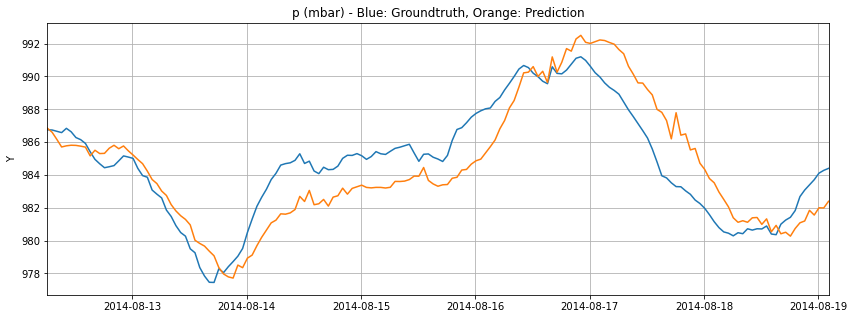

In [19]:
fig = plt.figure(figsize=(14,5))
plt.title('p (mbar) - Blue: Groundtruth, Orange: Prediction')
plt.ylabel('Y')
plt.grid(True)
plt.autoscale(axis='x', tight=True)


plot_gt = val_df['p (mbar)'][val_idx_start + sequence_length - 1 :val_idx_end+1] * p_std + p_mean
plot_gt.index = val_date_time[val_idx_start + sequence_length - 1:val_idx_end+1] 

plot_pred = output[..., 0] * p_std + p_mean

plt.plot(plot_gt)
plt.plot(val_date_time[val_idx_start + sequence_length - 1:val_idx_end+1], plot_pred)

plt.show()

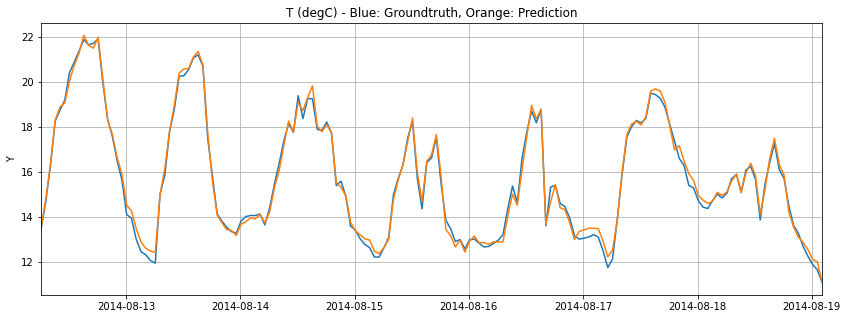

In [20]:
fig = plt.figure(figsize=(14,5))
plt.title('T (degC) - Blue: Groundtruth, Orange: Prediction')
plt.ylabel('Y')
plt.grid(True)
plt.autoscale(axis='x', tight=True)


plot_gt = val_df['T (degC)'][val_idx_start + sequence_length - 1:val_idx_end+1] * T_std + T_mean
plot_gt.index = val_date_time[val_idx_start + sequence_length - 1:val_idx_end+1] 

plot_pred = output[..., 1] * T_std + T_mean

plt.plot(plot_gt)
plt.plot(val_date_time[val_idx_start + sequence_length - 1:val_idx_end+1], plot_pred)

plt.show()